# EXCON: Extreme Instance-based Contrastive Representation Learning of Severely  Imbalanced Multivariate Time Series (Multiclass Version)

In heliophysics research, predicting solar flares is crucial due to their potential to substantially impact both space-based systems and Earth’s infrastructure. Magnetic field data from solar active regions, recorded by solar imaging observatories, are transformed into multivariate time series to enable solar flare prediction using temporal window-based analysis. In the realm of multivariate time series-driven solar flare prediction, addressing severe class imbalance with effective strategies for multivariate time series representation learning is key to developing robust predictive models. Traditional methods often struggle with overfitting to the majority class in prediction tasks where major solar flares are infrequent. This work presents EXCON, a contrastive representation learning framework designed to enhance classification performance amidst such imbalances. EXCON operates through four stages: (1) obtaining core features from multivariate time series data; (2) selecting distinctive contrastive representations for each class to maximize inter-class separation; (3) training a temporal feature embedding module with a custom extreme reconstruction loss to minimize intra-class variation; and (4) applying a classifier to the learned embeddings for robust classification. The proposed method leverages contrastive learning principles to map similar instances closer in the feature space while distancing dissimilar ones, a strategy not extensively explored in solar flare prediction tasks. This approach not only addresses class imbalance but also offers a versatile solution applicable to both univariate and multivariate time series across binary and multiclass classification problems. Experimental results, including evaluations on the benchmark solar flare dataset and multiple time series archive datasets with binary and multiclass labels, demonstrate EXCON's efficacy in enhancing classification performance and reducing overfitting.

In [1]:
import pycatch22
import pickle
import numpy as np
import os
import pandas as pd
import aeon
from natsort import natsorted
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from aeon.datasets import load_from_tsfile

C:\Users\user\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Binary Class Experiment Benchmarks

# BECNCHMARK**: SWAN-SF

In [5]:
cur_dir = Path.cwd()
parent_folder = cur_dir.parent / 'DATA' / 'Preprocessed-SWANSF-main' 

# Defining the paths
folder_path_train = str(parent_folder) + '/train/'
folder_path_test = str(parent_folder) + '/test/'
print(folder_path_train)

# Extracting train and test partitions
X_train = []
y_train = []
num_partitions = 5

for i in range(num_partitions):
    with open(f"{folder_path_train}Partition{i+1}_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", 'rb') as f:
        X_train.append(pickle.load(f))
    with open(f"{folder_path_train}Partition{i+1}_Labels_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", 'rb') as f:
        y_train.append(pickle.load(f))
        
X_test = []
y_test = []
num_partitions = 5

for i in range(num_partitions):
    with open(f"{folder_path_test}Partition{i+1}_LSBZM-Norm_FPCKNN-impute.pkl", 'rb') as f:
        X_test.append(pickle.load(f))
    with open(f"{folder_path_test}Partition{i+1}_Labels_LSBZM-Norm_FPCKNN-impute.pkl", 'rb') as f:
        y_test.append(pickle.load(f))

C:\Users\user\Desktop\2mvts-ss\DATA\Preprocessed-SWANSF-main/train/


In [6]:
SELECTED_PARTITION = 3
# Make list less deep 
X_train = X_train[SELECTED_PARTITION-1] # Training with partition 1
y_train = y_train[SELECTED_PARTITION-1] # Training with partition 1
X_test = X_test[SELECTED_PARTITION] # Testing with partition 2
y_test = y_test[SELECTED_PARTITION] # Testing with partition 2
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

DATASET_NAME = f"SWAN-SF_train_{SELECTED_PARTITION}"

(19965, 60, 24)
(19965,)
(51261, 60, 24)
(51261,)


# BENCHMARK: SWAN-SF MULTI

In [2]:
import os
import pandas as pd
from natsort import natsorted
from pathlib import Path

def load_and_label_data_FLARE(vf_parent_folder):
    data_list = []
    label_list = []

    # Get all sorted CSV files from the folder
    csv_files = natsorted([file for file in os.listdir(vf_parent_folder) if file.endswith('.csv')])

    # Loop through the sorted CSV files
    for file in csv_files:
        file_path = os.path.join(vf_parent_folder, file)
        
        # Check if the file starts with 'X' or 'M' and assign a label
        label = 'X' if file.startswith('X') else ('M' if file.startswith('M') else None)
        
        if label is None:
            continue
        
        # Read the CSV file
        df = pd.read_csv(file_path, sep='\t')
        
        # Extract the first 24 features
        first_24_features = df.iloc[:, 1:25]
        # Check for NaN values and skip if any are found
        if first_24_features.isnull().values.any():
            #print(f"Skipping {file} due to NaN values.")
            continue
        
        
        first_24_features_np = first_24_features.to_numpy()
        
        # Append the features and label to respective lists
        data_list.append(first_24_features_np)
        label_list.append(label)
    
    return data_list, label_list

In [3]:
import os
import pandas as pd
from natsort import natsorted
from pathlib import Path

def load_and_label_data_NONFLARE(vf_parent_folder):
    data_list = []
    label_list = []

    # Get all sorted CSV files from the folder
    csv_files = natsorted([file for file in os.listdir(vf_parent_folder) if file.endswith('.csv')])

    # Loop through the sorted CSV files
    for file in csv_files:
        file_path = os.path.join(vf_parent_folder, file)
        
        # Check if the file starts with 'FQ' or is either 'B' or 'C' and assign appropriate label
        if file.startswith('FQ'):
            label = 'FQ'
        elif file.startswith('B') or file.startswith('C'):
            label = 'BC'
        else:
            continue
        
        # Read the CSV file
        df = pd.read_csv(file_path, sep='\t')
        
        # Extract the first 24 features
        first_24_features = df.iloc[:, 1:25]
        
        # Check for NaN values and skip if any are found
        if first_24_features.isnull().values.any():
            # print(f"Skipping {file} due to NaN values.")
            continue
        
        first_24_features_np = first_24_features.to_numpy()
        
        # Append the features and label to respective lists
        data_list.append(first_24_features_np)
        label_list.append(label)
    
    return data_list, label_list


In [4]:
SELECTED_PARTITION = 3
DATASET_NAME = f"SWAN-SF_multi_train_{SELECTED_PARTITION}"

SELECTED_PARTITION_TEST = 4
TRAIN_NAME = f"SWAN-SF_multi_train_{SELECTED_PARTITION_TEST}"

In [5]:
# TRAIN FLARE
vf_dir = Path.cwd()
vf_parent_folder = vf_dir.parent / 'DATA' / f"partition{SELECTED_PARTITION}" / 'FL'
data_list_flare_train, label_list_flare_train = load_and_label_data_FLARE(vf_parent_folder)

print(f"Total valid files processed: {len(data_list_flare_train)}")

# Convert data and labels into NumPy arrays
data_list_flare_train_np = np.array(data_list_flare_train)
label_list_flare_train_np = np.array(label_list_flare_train)

# Print the dimensions of the NumPy arrays
print(f"Data list dimensions: {data_list_flare_train_np.shape}")
print(f"Label list dimensions: {label_list_flare_train_np.shape}")

Total valid files processed: 1277
Data list dimensions: (1277, 60, 24)
Label list dimensions: (1277,)


In [6]:
# TRAIN NONFLARE
vf_dir = Path.cwd()
vf_parent_folder = vf_dir.parent / 'DATA' / f"partition{SELECTED_PARTITION}" / 'NF'
data_list_nonflare_train, label_list_nonflare_train = load_and_label_data_NONFLARE(vf_parent_folder)

print(f"Total valid files processed: {len(data_list_nonflare_train)}")

# Convert data and labels into NumPy arrays
data_list_nonflare_train_np = np.array(data_list_nonflare_train)
label_list_nonflare_train_np = np.array(label_list_nonflare_train)

# Print the dimensions of the NumPy arrays
print(f"Data list dimensions: {data_list_nonflare_train_np.shape}")
print(f"Label list dimensions: {label_list_nonflare_train_np.shape}")


Total valid files processed: 36535
Data list dimensions: (36535, 60, 24)
Label list dimensions: (36535,)


In [7]:
# TEST FLARE:
vf_dir = Path.cwd()
vf_parent_folder = vf_dir.parent / 'DATA' / f"partition{SELECTED_PARTITION_TEST}" / 'FL'
data_list_flare_test, label_list_flare_test = load_and_label_data_FLARE(vf_parent_folder)

print(f"Total valid files processed: {len(data_list_flare_test)}")

# Convert data and labels into NumPy arrays
data_list_flare_test_np = np.array(data_list_flare_test)
label_list_flare_test_np = np.array(label_list_flare_test)

# Print the dimensions of the NumPy arrays
print(f"Data list dimensions: {data_list_flare_test_np.shape}")
print(f"Label list dimensions: {label_list_flare_test_np.shape}")

Total valid files processed: 890
Data list dimensions: (890, 60, 24)
Label list dimensions: (890,)


In [8]:
# TEST NONFLARE:
vf_dir = Path.cwd()
vf_parent_folder = vf_dir.parent / 'DATA' / f"partition{SELECTED_PARTITION_TEST}" / 'NF'
data_list_nonflare_test, label_list_nonflare_test = load_and_label_data_NONFLARE(vf_parent_folder)

print(f"Total valid files processed: {len(label_list_nonflare_test)}")

# Convert data and labels into NumPy arrays
data_list_nonflare_test_np = np.array(data_list_nonflare_test)
label_list_nonflare_test_np = np.array(label_list_nonflare_test)

# Print the dimensions of the NumPy arrays
print(f"Data list dimensions: {data_list_nonflare_test_np.shape}")
print(f"Label list dimensions: {label_list_nonflare_test_np.shape}")

Total valid files processed: 42695
Data list dimensions: (42695, 60, 24)
Label list dimensions: (42695,)


In [9]:
import numpy as np
from sklearn.utils import shuffle

# Assuming you have loaded both FLARE and NONFLARE datasets for both train and test

# Combine the training data and labels
X_train = np.concatenate((data_list_flare_train_np, data_list_nonflare_train_np), axis=0)
y_train = np.concatenate((label_list_flare_train_np, label_list_nonflare_train_np), axis=0)

# Shuffle the training data and labels
X_train, y_train = shuffle(X_train, y_train, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


# Combine the test data and labels
X_test = np.concatenate((data_list_flare_test_np, data_list_nonflare_test_np), axis=0)
y_test = np.concatenate((label_list_flare_test_np, label_list_nonflare_test_np), axis=0)

# Shuffle the test data and labels
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (37812, 60, 24)
y_train shape: (37812,)
X_test shape: (43585, 60, 24)
y_test shape: (43585,)


In [10]:
print("Unique class labels ", np.unique(y_train))

label_to_int = {'FQ': 0, 'BC': 1, 'M': 2, 'X': 3}

# Convert the labels to integers
y_train = np.array([label_to_int[label] for label in y_train])  # Convert to NumPy array
y_test = np.array([label_to_int[label] for label in y_test])    # Convert to NumPy array



Unique class labels  ['BC' 'FQ' 'M' 'X']


In [11]:
print("Unique class labels ", np.unique(y_train))
print(y_train)
print(y_test)

Unique class labels  [0 1 2 3]
[1 0 0 ... 0 2 0]
[0 3 0 ... 0 3 0]


# BECNCHMARK: FaceDetection

In [187]:
#DATA_PATH = os.path.join(os.path.dirname(aeon.__file__), "datasets/data")
cur_dir = Path.cwd()
path = cur_dir.parent / 'DATA'  

DATASET_NAME = "FaceDetection"
X_train, y_train = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TRAIN.ts")
X_test, y_test = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TEST.ts")

X_train = np.transpose(X_train, (0, 2, 1))  # Change shape to (n_cases, n_timepoints, n_channels)
X_test = np.transpose(X_test, (0, 2, 1))    # Change shape to (n_cases, n_timepoints, n_channels)

y_train = y_train.astype(int)  # Convert to integers if they are strings
y_test = y_test.astype(int)  # Convert to integers if they are strings

print("Unique class labels ", np.unique(y_train))

print("Type of the first element in train_x:", type(X_train[0]))
print("Shape of the first element in train_x:", X_train[0].shape)

print(" Shape of train_x = ", X_train.shape, "- y_train shape = ", y_train.shape) 
print(X_train)
print(y_train)

print(" Shape of test_x = ", X_test.shape, "- y_test shape = ", y_test.shape)
print(X_test)
print(y_test)

Unique class labels  [0 1]
Type of the first element in train_x: <class 'numpy.ndarray'>
Shape of the first element in train_x: (62, 144)
 Shape of train_x =  (5890, 62, 144) - y_train shape =  (5890,)
[[[-0.07545   0.05608  -0.824537 ... -0.56758  -0.23404  -0.356189]
  [-0.336703 -0.128013 -0.746068 ... -1.073942  0.104291 -0.511199]
  [-0.278238 -0.323847 -0.482871 ... -1.136367  0.327425 -0.483072]
  ...
  [-0.411078 -2.114348 -0.929275 ... -0.541122 -1.458801 -1.177502]
  [-1.016122  0.208789 -1.007972 ... -0.765445  0.318952 -0.728301]
  [-1.161735 -0.509533 -0.292018 ... -1.73308   1.854007 -0.400074]]

 [[-0.093192 -1.584982 -0.462859 ... -0.056147 -0.71979  -0.444479]
  [-0.310616 -1.138981 -0.301394 ... -0.051994 -0.624242 -0.386303]
  [-0.388905 -0.852494 -0.50619  ... -0.195028 -0.548486 -0.436634]
  ...
  [ 1.937879 -0.334188  0.864706 ... -2.212319  0.276439 -0.855299]
  [ 0.978442  0.636669  0.113177 ... -1.052363  1.380659  0.879662]
  [ 0.626839  0.078561 -0.337559 ...

# BECNCHMARK: Earthquakes

In [143]:
cur_dir = Path.cwd()
path = cur_dir.parent / 'DATA'  

DATASET_NAME = "Earthquakes"
X_train, y_train = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TRAIN.ts")
X_test, y_test = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TEST.ts")

X_train = np.transpose(X_train, (0, 2, 1))  # Change shape to (n_cases, n_timepoints, n_channels)
X_test = np.transpose(X_test, (0, 2, 1))    # Change shape to (n_cases, n_timepoints, n_channels)

y_train = y_train.astype(int)  # Convert to integers if they are strings
y_test = y_test.astype(int)  # Convert to integers if they are strings

print("Unique class labels ", np.unique(y_train))

print("Type of the first element in train_x:", type(X_train[0]))
print("Shape of the first element in train_x:", X_train[0].shape)

print(" Shape of train_x = ", X_train.shape, "- y_train shape = ", y_train.shape) 
print(X_train)
print(y_train)

print(" Shape of test_x = ", X_test.shape, "- y_test shape = ", y_test.shape)
print(X_test)
print(y_test)

Unique class labels  [0 1]
Type of the first element in train_x: <class 'numpy.ndarray'>
Shape of the first element in train_x: (512, 1)
 Shape of train_x =  (322, 512, 1) - y_train shape =  (322,)
[[[-0.51800895]
  [-0.51800895]
  [ 2.6542109 ]
  ...
  [-0.51800895]
  [ 1.4658264 ]
  [-0.51800895]]

 [[ 1.9437326 ]
  [-0.35311462]
  [-0.35311462]
  ...
  [-0.35311462]
  [-0.35311462]
  [-0.35311462]]

 [[ 2.6385165 ]
  [-0.31610235]
  [-0.31610235]
  ...
  [-0.31610235]
  [-0.31610235]
  [-0.31610235]]

 ...

 [[-0.26465174]
  [-0.26465174]
  [-0.26465174]
  ...
  [-0.26465174]
  [-0.26465174]
  [-0.26465174]]

 [[-0.49082731]
  [-0.49082731]
  [-0.49082731]
  ...
  [-0.49082731]
  [-0.49082731]
  [-0.49082731]]

 [[-0.4839215 ]
  [-0.4839215 ]
  [-0.4839215 ]
  ...
  [-0.4839215 ]
  [-0.4839215 ]
  [-0.4839215 ]]]
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0
 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0

# Benchmark: ElectricDeviceDetection

In [51]:
cur_dir = Path.cwd()
path = cur_dir.parent / 'DATA'  

DATASET_NAME = "ElectricDeviceDetection"
X_train, y_train = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TRAIN.ts")
X_test, y_test = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TEST.ts")

X_train = np.transpose(X_train, (0, 2, 1))  # Change shape to (n_cases, n_timepoints, n_channels)
X_test = np.transpose(X_test, (0, 2, 1))    # Change shape to (n_cases, n_timepoints, n_channels)

y_train = y_train.astype(int)  # Convert to integers if they are strings
y_test = y_test.astype(int)  # Convert to integers if they are strings

print("Unique class labels ", np.unique(y_train))

print("Type of the first element in train_x:", type(X_train[0]))
print("Shape of the first element in train_x:", X_train[0].shape)

print(" Shape of train_x = ", X_train.shape, "- y_train shape = ", y_train.shape) 
print(X_train)
print(y_train)

print(" Shape of test_x = ", X_test.shape, "- y_test shape = ", y_test.shape)
print(X_test)
print(y_test)

Unique class labels  [0 1]
Type of the first element in train_x: <class 'numpy.ndarray'>
Shape of the first element in train_x: (256, 1)
 Shape of train_x =  (624, 256, 1) - y_train shape =  (624,)
[[[   0.]
  [   0.]
  [   0.]
  ...
  [   9.]
  [   5.]
  [ 883.]]

 [[   0.]
  [   0.]
  [   0.]
  ...
  [  17.]
  [  14.]
  [4291.]]

 [[   0.]
  [   0.]
  [   0.]
  ...
  [   0.]
  [   0.]
  [   0.]]

 ...

 [[   0.]
  [   0.]
  [   0.]
  ...
  [   0.]
  [   0.]
  [   0.]]

 [[   0.]
  [   0.]
  [   0.]
  ...
  [   0.]
  [   0.]
  [   0.]]

 [[   0.]
  [   0.]
  [   0.]
  ...
  [   0.]
  [   0.]
  [   0.]]]
[0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 

# Benchmark: FingerMovements

In [228]:
cur_dir = Path.cwd()
path = cur_dir.parent / 'DATA'  

DATASET_NAME = "FingerMovements"
X_train, y_train = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TRAIN.ts")
X_test, y_test = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TEST.ts")

X_train = np.transpose(X_train, (0, 2, 1))  # Change shape to (n_cases, n_timepoints, n_channels)
X_test = np.transpose(X_test, (0, 2, 1))    # Change shape to (n_cases, n_timepoints, n_channels)

label_to_int = {'left': 0, 'right': 1}

# Convert the labels to integers
y_train = np.array([label_to_int[label] for label in y_train])  # Convert to NumPy array
y_test = np.array([label_to_int[label] for label in y_test])    # Convert to NumPy array
print("Unique class labels ", np.unique(y_train))

print("Type of the first element in train_x:", type(X_train[0]))
print("Shape of the first element in train_x:", X_train[0].shape)

print(" Shape of train_x = ", X_train.shape, "- y_train shape = ", y_train.shape) 
print(X_train)
print(y_train)

print(" Shape of test_x = ", X_test.shape, "- y_test shape = ", y_test.shape)
print(X_test)
print(y_test)

Unique class labels  [0 1]
Type of the first element in train_x: <class 'numpy.ndarray'>
Shape of the first element in train_x: (50, 28)
 Shape of train_x =  (316, 50, 28) - y_train shape =  (316,)
[[[ 41.8  55.2  -8.6 ...  16.9  42.2  13. ]
  [ 44.8  53.8  -3.6 ...  24.5  35.   26.6]
  [ 47.1  59.9  14.4 ...  24.5  41.7  52.5]
  ...
  [ 69.8  17.5  23.3 ...  51.9  51.5  -3.5]
  [ 72.6  28.   35.9 ...  59.6  58.5  -3.2]
  [ 76.1  12.1  23.2 ...  57.3  46.9  -2.6]]

 [[132.   99.7  18.7 ... -11.2 -21.7 -41.3]
  [137.   95.8   0.8 ... -11.6 -21.1 -40.2]
  [148.   99.5  20.  ... -13.8 -23.6 -33.3]
  ...
  [ 78.1 -39.9   0.9 ... -31.9 -57.8 -51.1]
  [ 90.5 -10.2  31.6 ... -19.9 -44.6 -45.4]
  [ 85.7 -37.4   7.3 ... -25.7 -45.6 -42.5]]

 [[ 69.4  67.8   9.9 ...  20.9  14.1   3.6]
  [ 57.   49.  -12.4 ...  20.5   7.9  11. ]
  [ 76.4  62.1  18.7 ...  30.1   6.3  14. ]
  ...
  [ 55.6 -16.6  18.7 ...  16.6   7.6   2.2]
  [ 67.7  12.2  55.4 ...  14.   12.1  -5.4]
  [ 59.  -14.6  10.9 ...  16.4  

# MULTICLASS EXPERIMENT BENCHMARKS

# Benchmark: ElectricDevices

In [269]:
cur_dir = Path.cwd()
path = cur_dir.parent / 'DATA'  

DATASET_NAME = "ElectricDevices"
X_train, y_train = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TRAIN.ts")
X_test, y_test = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TEST.ts")

X_train = np.transpose(X_train, (0, 2, 1))  # Change shape to (n_cases, n_timepoints, n_channels)
X_test = np.transpose(X_test, (0, 2, 1))    # Change shape to (n_cases, n_timepoints, n_channels)

y_train = y_train.astype(int)  # Convert to integers if they are strings
y_test = y_test.astype(int)  # Convert to integers if they are strings

y_train = y_train - y_train.min()
y_test = y_test - y_test.min()

print("Unique class labels ", np.unique(y_train))

print("Type of the first element in train_x:", type(X_train[0]))
print("Shape of the first element in train_x:", X_train[0].shape)

print(" Shape of train_x = ", X_train.shape, "- y_train shape = ", y_train.shape) 
print(X_train)
print(y_train)

print(" Shape of test_x = ", X_test.shape, "- y_test shape = ", y_test.shape)
print(X_test)
print(y_test)

Unique class labels  [0 1 2 3 4 5 6]
Type of the first element in train_x: <class 'numpy.ndarray'>
Shape of the first element in train_x: (96, 1)
 Shape of train_x =  (8926, 96, 1) - y_train shape =  (8926,)
[[[-0.18610903]
  [-0.18610903]
  [-0.18610903]
  ...
  [-0.18610903]
  [-0.18610903]
  [-0.18610903]]

 [[-0.17700482]
  [-0.17700482]
  [-0.17700482]
  ...
  [-0.17700482]
  [-0.17700482]
  [-0.17700482]]

 [[-0.21353499]
  [-0.21353499]
  [-0.21353499]
  ...
  [-0.21353499]
  [-0.21353499]
  [-0.21353499]]

 ...

 [[-0.39939354]
  [-0.39939354]
  [-0.39939354]
  ...
  [-0.39939354]
  [-0.39939354]
  [-0.39939354]]

 [[-0.59559852]
  [-0.59559852]
  [-0.59559852]
  ...
  [ 1.8712256 ]
  [ 1.8712256 ]
  [ 1.7831247 ]]

 [[-0.54518251]
  [-0.54518251]
  [-0.54518251]
  ...
  [-0.54518251]
  [-0.54518251]
  [-0.54518251]]]
[0 0 0 ... 4 4 4]
 Shape of test_x =  (7711, 96, 1) - y_test shape =  (7711,)
[[[-0.19621202]
  [-0.19621202]
  [-0.19621202]
  ...
  [-0.19621202]
  [-0.19621202

# Benchmark: Crop

In [351]:
cur_dir = Path.cwd()
path = cur_dir.parent / 'DATA'  

DATASET_NAME = "Crop"
X_train, y_train = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TRAIN.ts")
X_test, y_test = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TEST.ts")

X_train = np.transpose(X_train, (0, 2, 1))  # Change shape to (n_cases, n_timepoints, n_channels)
X_test = np.transpose(X_test, (0, 2, 1))    # Change shape to (n_cases, n_timepoints, n_channels)

y_train = y_train.astype(int)  # Convert to integers if they are strings
y_test = y_test.astype(int)  # Convert to integers if they are strings

y_train = y_train - y_train.min()
y_test = y_test - y_test.min()

print("Unique class labels ", np.unique(y_train))

print("Type of the first element in train_x:", type(X_train[0]))
print("Shape of the first element in train_x:", X_train[0].shape)

print(" Shape of train_x = ", X_train.shape, "- y_train shape = ", y_train.shape) 
print(X_train)
print(y_train)

print(" Shape of test_x = ", X_test.shape, "- y_test shape = ", y_test.shape)
print(X_test)
print(y_test)

Unique class labels  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Type of the first element in train_x: <class 'numpy.ndarray'>
Shape of the first element in train_x: (46, 1)
 Shape of train_x =  (7200, 46, 1) - y_train shape =  (7200,)
[[[ 0.24 ]
  [ 0.257]
  [ 0.274]
  ...
  [ 0.35 ]
  [ 0.333]
  [ 0.316]]

 [[ 0.219]
  [ 0.209]
  [ 0.199]
  ...
  [ 0.239]
  [ 0.218]
  [ 0.197]]

 [[ 0.281]
  [ 0.24 ]
  [ 0.199]
  ...
  [ 0.286]
  [ 0.306]
  [ 0.326]]

 ...

 [[-0.103]
  [-0.097]
  [-0.091]
  ...
  [-0.011]
  [ 0.143]
  [ 0.297]]

 [[ 0.453]
  [ 0.111]
  [-0.231]
  ...
  [ 0.343]
  [ 0.257]
  [ 0.171]]

 [[ 0.286]
  [ 0.2  ]
  [-0.185]
  ...
  [ 0.266]
  [ 0.208]
  [ 0.15 ]]]
[ 0  0  0 ... 23 23 23]
 Shape of test_x =  (16800, 46, 1) - y_test shape =  (16800,)
[[[ 0.178]
  [ 0.172]
  [ 0.158]
  ...
  [ 0.235]
  [ 0.211]
  [ 0.187]]

 [[ 0.203]
  [ 0.2  ]
  [ 0.197]
  ...
  [ 0.524]
  [ 0.556]
  [ 0.588]]

 [[ 0.258]
  [ 0.248]
  [ 0.261]
  ...
  [ 0.27 ]


# Benchmark: PenDigits

In [393]:
cur_dir = Path.cwd()
path = cur_dir.parent / 'DATA'  

DATASET_NAME = "PenDigits"
X_train, y_train = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TRAIN.ts")
X_test, y_test = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TEST.ts")

X_train = np.transpose(X_train, (0, 2, 1))  # Change shape to (n_cases, n_timepoints, n_channels)
X_test = np.transpose(X_test, (0, 2, 1))    # Change shape to (n_cases, n_timepoints, n_channels)

y_train = y_train.astype(int)  # Convert to integers if they are strings
y_test = y_test.astype(int)  # Convert to integers if they are strings

print("Unique class labels ", np.unique(y_train))

print("Type of the first element in train_x:", type(X_train[0]))
print("Shape of the first element in train_x:", X_train[0].shape)

print(" Shape of train_x = ", X_train.shape, "- y_train shape = ", y_train.shape) 
print(X_train)
print(y_train)

print(" Shape of test_x = ", X_test.shape, "- y_test shape = ", y_test.shape)
print(X_test)
print(y_test)

Unique class labels  [0 1 2 3 4 5 6 7 8 9]
Type of the first element in train_x: <class 'numpy.ndarray'>
Shape of the first element in train_x: (8, 2)
 Shape of train_x =  (7494, 8, 2) - y_train shape =  (7494,)
[[[ 47. 100.]
  [ 27.  81.]
  [ 57.  37.]
  ...
  [ 56.  53.]
  [100.  90.]
  [ 40.  98.]]

 [[  0.  89.]
  [ 27. 100.]
  [ 42.  75.]
  ...
  [ 37.   0.]
  [ 69.   2.]
  [100.   6.]]

 [[  0.  57.]
  [ 31.  68.]
  [ 72.  90.]
  ...
  [ 50.  51.]
  [ 28.  25.]
  [ 16.   0.]]

 ...

 [[100.  98.]
  [ 60. 100.]
  [ 24.  87.]
  ...
  [ 58.  26.]
  [ 36.   0.]
  [  0.   5.]]

 [[ 59.  65.]
  [ 91. 100.]
  [ 84.  96.]
  ...
  [  0.   0.]
  [ 45.   1.]
  [100.   0.]]

 [[  0.  78.]
  [ 29. 100.]
  [ 94.  86.]
  ...
  [ 32.   0.]
  [ 25.  36.]
  [100.  40.]]]
[8 2 1 ... 5 1 7]
 Shape of test_x =  (3498, 8, 2) - y_test shape =  (3498,)
[[[ 88.  92.]
  [  2.  99.]
  [ 16.  66.]
  ...
  [  0.  24.]
  [ 42.  65.]
  [100. 100.]]

 [[ 80. 100.]
  [ 18.  98.]
  [ 60.  66.]
  ...
  [  0.  23.]

# Benchmark: LSST

In [2]:
cur_dir = Path.cwd()
path = cur_dir.parent / 'DATA'  

DATASET_NAME = "LSST"
X_train, y_train = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TRAIN.ts")
X_test, y_test = load_from_tsfile(path / DATASET_NAME / f"{DATASET_NAME}_TEST.ts")

X_train = np.transpose(X_train, (0, 2, 1))  # Change shape to (n_cases, n_timepoints, n_channels)
X_test = np.transpose(X_test, (0, 2, 1))    # Change shape to (n_cases, n_timepoints, n_channels)

label_to_int = {'15': 1, '16': 2 ,'42': 3 ,'52': 4, '53': 5, '6': 0 ,'62': 6, '64': 7 ,'65': 8, '67': 9 ,'88': 10, '90': 11, '92': 12, '95': 13}

# Convert the labels to integers
y_train = np.array([label_to_int[label] for label in y_train])  # Convert to NumPy array
y_test = np.array([label_to_int[label] for label in y_test])    # Convert to NumPy array


print("Unique class labels ", np.unique(y_train))

print("Type of the first element in train_x:", type(X_train[0]))
print("Shape of the first element in train_x:", X_train[0].shape)

print(" Shape of train_x = ", X_train.shape, "- y_train shape = ", y_train.shape) 
print(X_train)
print(y_train)

print(" Shape of test_x = ", X_test.shape, "- y_test shape = ", y_test.shape)
print(X_test)
print(y_test)

Unique class labels  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Type of the first element in train_x: <class 'numpy.ndarray'>
Shape of the first element in train_x: (36, 6)
 Shape of train_x =  (2459, 36, 6) - y_train shape =  (2459,)
[[[ 1.7597e+01  8.1713e+00 -1.7842e+00 -1.9706e+01 -9.7135e+00
   -6.1887e+01]
  [ 2.2974e-01 -5.8956e+00  1.6837e+01  5.0390e+00  2.4332e+00
    5.8914e+01]
  [-2.9654e+01 -2.1296e+01  2.9103e+01 -4.7503e-01  7.5391e+01
    1.0665e+01]
  ...
  [ 1.1982e+02  2.1849e+02  1.6398e+03  5.9787e+02  2.1922e+03
    1.8484e+01]
  [ 9.1591e+01  1.0378e+02  1.8238e+03  1.2460e+03  1.1301e+04
    7.5107e+02]
  [ 4.3719e+01  3.0689e+01  9.5092e+02  8.5927e+02  8.1331e+03
    9.8883e+02]]

 [[ 2.4209e+00 -5.6039e-01  2.3654e+01 -3.8171e+00  1.3721e+00
    8.2510e+00]
  [ 1.6847e+00  2.3989e+01  1.7803e+01 -1.9575e+01 -8.2534e+00
   -2.3959e+01]
  [ 5.0692e-01  5.0281e+01  5.1196e+01  1.6036e+01  7.2974e-01
   -1.8185e+01]
  ...
  [-1.5618e+01 -7.4233e+00  3.7833e+00 

# OPTIONAL: STANDARD NORMALIZATION OF DATA POINTS

In [25]:
from sklearn.preprocessing import StandardScaler

# Reshape the data to 2D for normalization
n_cases_train, n_timepoints_train, n_channels_train = X_train.shape
n_cases_test, n_timepoints_test, n_channels_test = X_test.shape

X_train_reshaped = X_train.reshape(-1, n_channels_train)
X_test_reshaped = X_test.reshape(-1, n_channels_test)

# Apply standard scaling
scaler = StandardScaler()
X_train_reshaped = scaler.fit_transform(X_train_reshaped)
X_test_reshaped = scaler.transform(X_test_reshaped)

# Reshape back to the original 3D shape
X_train = X_train_reshaped.reshape(n_cases_train, n_timepoints_train, n_channels_train)
X_test = X_test_reshaped.reshape(n_cases_test, n_timepoints_test, n_channels_test)

# Now X_train and X_test are normalized and ready for use
print("Normalized X_train shape:", X_train.shape)
print("Normalized X_test shape:", X_test.shape)


Normalized X_train shape: (2459, 36, 6)
Normalized X_test shape: (2466, 36, 6)


* Direct classification

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(X_train_flat.shape)
print(X_test_flat.shape)

(37812, 1440)
(43585, 1440)


# BASELINES

In [16]:
# BASELINE: Vector MVTS (VMVTS)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Detect the number of unique classes
num_classes = len(np.unique(y_train))

logreg_model = LogisticRegression(max_iter=1000)

# Train the Logistic Regression model
logreg_model.fit(X_train_flat, y_train)

y_pred = logreg_model.predict(X_test_flat)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Precision, Recall, F1 Score (Weighted)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro') if num_classes > 2 else precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro') if num_classes > 2 else recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro') if num_classes > 2 else f1_score(y_test, y_pred)

if num_classes > 2:
    # For multiclass ROC AUC
    y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))
    y_pred_prob = logreg_model.predict_proba(X_test_flat)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr', average='macro')
else:
    y_pred_prob = logreg_model.predict_proba(X_test_flat)[:, 1]  # Probabilities for positive class
    roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Model Evaluation Metrics:
Accuracy: 0.8412756682344843
Precision: 0.21031891705862107
Recall: 0.25
F1 Score: 0.22844913522404428
ROC AUC Score: 0.5


In [17]:
# BASELINE: LTV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Detect the number of unique classes
num_classes = len(np.unique(y_train))


# Extract the last row for each instance
X_train_LTV = X_train[:, -1, :]
X_test_LTV = X_test[:, -1, :]
print(X_train_LTV.shape) 
print(X_test_LTV.shape)

logreg_model = LogisticRegression(max_iter=1000)

# Train the Logistic Regression model
logreg_model.fit(X_train_LTV, y_train)

y_pred = logreg_model.predict(X_test_LTV)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Precision, Recall, F1 Score (Weighted)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro') if num_classes > 2 else precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro') if num_classes > 2 else recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro') if num_classes > 2 else f1_score(y_test, y_pred)

if num_classes > 2:
    # For multiclass ROC AUC
    y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))
    y_pred_prob = logreg_model.predict_proba(X_test_LTV)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr', average='macro')
else:
    y_pred_prob = logreg_model.predict_proba(X_test_LTV)[:, 1]  # Probabilities for positive class
    roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

(37812, 24)
(43585, 24)
Model Evaluation Metrics:
Accuracy: 0.8412756682344843
Precision: 0.21031891705862107
Recall: 0.25
F1 Score: 0.22844913522404428
ROC AUC Score: 0.5


In [18]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import numpy as np

# Detect the number of unique classes
num_classes = len(np.unique(y_train))

# Convert labels to categorical if multiclass
if num_classes > 2:
    print("multi classification")
    y_train_encoded = to_categorical(y_train, num_classes=num_classes)
    y_test_encoded = to_categorical(y_test, num_classes=num_classes)
else:
    print("binary classification")
    y_train_encoded = y_train  # For binary classification
    y_test_encoded = y_test

# Define the LSTM model
lstm_model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(num_classes, activation='softmax') if num_classes > 2 else Dense(1, activation='sigmoid')
])


optimizer = SGD(learning_rate=0.0001)
lstm_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=2,           
    restore_best_weights=True  
)

print(X_train.shape)
print(X_test.shape)

# early stopping
lstm_model.fit(
    X_train, 
    y_train_encoded, 
    epochs=5,  # Increased epochs since early stopping will stop when necessary
    validation_split=0.2,  # Use a portion of the training data for validation
    callbacks=[early_stopping]  # Include early stopping in the training process
)

# Evaluate the model
y_pred_proba = lstm_model.predict(X_test)

if num_classes > 2:
    y_pred = y_pred_proba.argmax(axis=-1)
    roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr', average='macro')
else:
    y_pred = (y_pred_proba > 0.5).astype("int32").flatten()
    roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro') if num_classes > 2 else precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro') if num_classes > 2 else recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro') if num_classes > 2 else f1_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

y_test

multi classification
(37812, 60, 24)
(43585, 60, 24)
Epoch 1/5
946/946 [==============================] - 22s 22ms/step - loss: 1.0263 - accuracy: 0.6798 - val_loss: 0.9125 - val_accuracy: 0.7648
Epoch 2/5
946/946 [==============================] - 21s 22ms/step - loss: 0.8343 - accuracy: 0.7940 - val_loss: 0.7854 - val_accuracy: 0.8042
Epoch 3/5
946/946 [==============================] - 21s 22ms/step - loss: 0.7416 - accuracy: 0.8132 - val_loss: 0.7222 - val_accuracy: 0.8075
Epoch 4/5
946/946 [==============================] - 21s 22ms/step - loss: 0.6933 - accuracy: 0.8140 - val_loss: 0.6876 - val_accuracy: 0.8077
Epoch 5/5
1363/1363 [==============================] - 11s 8ms/step
Model Evaluation Metrics:
Accuracy: 0.840472639669611
Precision: 0.3641693569334669
Recall: 0.25215480126323986
F1 Score: 0.23314845416579033
ROC AUC Score: 0.5204680034004552


array([0, 3, 0, ..., 0, 3, 0])

In [14]:
# BASELINE: ROCKET
from sktime.classification.kernel_based import RocketClassifier
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Detect the number of unique classes
num_classes = len(np.unique(y_train))
# Create and train classifier
classifier = RocketClassifier(num_kernels=1000)
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)  
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro') if num_classes > 2 else precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro') if num_classes > 2 else recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro') if num_classes > 2 else f1_score(y_test, y_pred)

y_pred_prob = classifier.predict_proba(X_test)

# Calculate ROC AUC score
if num_classes > 2:
    # For multiclass ROC AUC
    y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))
    roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr', average='macro')
else:
    # For binary ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])  # Probabilities for the positive class

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

(37812, 60, 24) (37812,) (43585, 60, 24) (43585,)


NameError: name 'precision_score' is not defined

# BASELINES END

# START OF MODEL

# Extracting Catch22 features of benchmark data

In [21]:
import numpy as np
def get_catch22(ts_data_list, mvts_dimension, name):
    catch22_features = []
    for mvts in ts_data_list:
        instance_features = []
        for i in range(mvts_dimension):
            # Compute Catch22 features for each univariate time series in mvts instance
            univariate_ts = mvts[:, i]
            variable_features = pycatch22.catch22_all(univariate_ts)
            values = variable_features['values']   
            # Safeguard against nan values
            values = np.nan_to_num(values, nan=0)
            instance_features.extend(values)

        # Append features to the list
        catch22_features.append(instance_features)
    path = cur_dir.parent / 'DATA' / 'catch22' / name
    # Convert the list of feature vectors to a DataFrame
    df_catch22 = pd.DataFrame(catch22_features)
    # Save the DataFrame to a CSV file
    df_catch22.to_csv(path, index=False)

    print(f"Saved Catch22 features to {path}")


In [ ]:
cur_dir = Path.cwd()

dataset_name = f"{DATASET_NAME}_train_c22"

get_catch22(X_train, X_train.shape[2], dataset_name)

# Getting the centroids

In [ ]:
dataset_name = f"{DATASET_NAME}_train_c22"
path = cur_dir.parent / 'DATA' / 'catch22' / dataset_name
df_catch22 = pd.read_csv(path)
df_catch22

In [ ]:
y_train_series = pd.Series(y_train)

# Add the class labels as a new column in df_catch22
df_catch22['class_label'] = y_train_series.values

# Print the shape and the first few rows to verify
print(f"Shape of df_catch22 with class labels: {df_catch22.shape}")

In [ ]:
df_catch22

# Finding the extreme points

In [13]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist


# Dictionary to hold the maximum distance object for each class
max_distance_objects = {}

class_column = 'class_label'
X = df_catch22.iloc[:, :-1]
y = df_catch22[class_column]

# Get unique classes
classes = y.unique()

# Dictionary to hold the maximum distance object for each class
max_distance_objects = {}

# Loop through each class
for c in classes:
    # Data for the current class
    X_c = X[y == c]
    
    # Data for all other classes
    X_not_c = X[y != c]
    
    # Compute the pairwise distance between all points in the current class and all other classes
    distances = cdist(X_c, X_not_c, metric='euclidean')
    
    # Find the maximum distance for each object in the current class
    max_distances = distances.max(axis=1)
    
    # Identify the object with the maximum distance
    max_index = np.argmax(max_distances)
    
    # Record the object and its class
    max_distance_objects[c] = df_catch22.iloc[X_c.index[max_index]]

# Convert the result into a DataFrame
max_distance_df = pd.DataFrame(max_distance_objects).T

print(max_distance_df)

           0         1         2     3         4         5         6     7  \
0  -0.544235 -0.734620  3.608531   9.0  0.556384 -0.067863  0.800000   8.0   
1  -0.468654 -0.194704  1.314425   3.0  0.084386 -0.648234  0.685714   3.0   
2  -0.381723 -0.086957  0.647179   2.0  0.092810 -3.906089  1.000000   6.0   
3   0.043842 -0.170966  1.715245  30.0  0.144101 -0.491227  0.228571   5.0   
4  -0.456533 -0.225858  1.675290   4.0  0.304012  1.713039  1.000000   5.0   
5   0.618548  0.819766  1.786306   4.0  0.200172  0.103839  0.971429   6.0   
6  -0.396108 -0.538994  4.419893  20.0  0.385277  0.268203  0.685714   8.0   
7  -0.214747 -0.646875  1.166417   3.0  0.374395 -0.064956  1.000000   5.0   
8   0.126461  0.419693  0.922952   3.0  0.192310 -1.216782  1.000000   5.0   
9  -0.539624  0.089741  0.713235   2.0  0.257638 -0.259651  0.971429   6.0   
10  0.548102  0.695119  7.436293  22.0  0.615785 -0.054330  0.800000  21.0   
11  0.080213 -0.149660  0.542846   1.0  0.280018  3.019646  1.00

In [14]:
extreme_name = f"{DATASET_NAME}_extremes"
path = cur_dir.parent / 'DATA' / 'catch22' / extreme_name

#max_distance_df_clean = max_distance_df.drop(columns=[class_column], errors='ignore')
#max_distance_df_clean
max_distance_df.to_csv(path, index=False)

In [15]:
extreme_name = f"{DATASET_NAME}_extremes"
path = cur_dir.parent / 'DATA' / 'catch22' / extreme_name
df_extremes = pd.read_csv(path)
df_extremes

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,class_label
0,-0.544235,-0.734620,3.608531,9.0,0.556384,-0.067863,0.800000,8.0,0.040000,10.0,...,0.944444,-0.083333,0.546995,4.0,2.149374,0.428571,0.571429,0.490874,0.623688,0.0
1,-0.468654,-0.194704,1.314425,3.0,0.084386,-0.648234,0.685714,3.0,0.022039,0.0,...,-0.694444,0.055556,0.186837,3.0,2.156593,0.500000,0.500000,1.865321,0.897542,1.0
2,-0.381723,-0.086957,0.647179,2.0,0.092810,-3.906089,1.000000,6.0,0.004614,4.0,...,-0.722222,-0.805556,0.173560,4.0,1.965453,0.428571,0.428571,1.472622,0.988624,2.0
3,0.043842,-0.170966,1.715245,30.0,0.144101,-0.491227,0.228571,5.0,0.034014,0.0,...,0.916667,-0.111111,0.587413,4.0,2.169565,0.428571,0.571429,0.392699,0.745671,3.0
4,-0.456533,-0.225858,1.675290,4.0,0.304012,1.713039,1.000000,5.0,0.020833,7.0,...,-0.250000,-0.111111,0.348106,4.0,2.094816,0.500000,0.500000,0.785398,1.157020,4.0
5,0.618548,0.819766,1.786306,4.0,0.200172,0.103839,0.971429,6.0,0.038567,7.0,...,0.666667,-0.166667,0.230151,5.0,1.997331,0.571429,0.571429,0.589049,1.140711,5.0
6,-0.396108,-0.538994,4.419893,20.0,0.385277,0.268203,0.685714,8.0,0.125000,0.0,...,0.861111,-0.222222,0.829384,4.0,1.955745,0.571429,0.571429,0.196350,0.335289,6.0
7,-0.214747,-0.646875,1.166417,3.0,0.374395,-0.064956,1.000000,5.0,0.021915,4.0,...,-0.416667,-0.277778,0.122645,4.0,2.084278,0.571429,0.500000,1.472622,1.194157,7.0
8,0.126461,0.419693,0.922952,3.0,0.192310,-1.216782,1.000000,5.0,0.014994,8.0,...,-0.305556,-0.305556,0.129612,3.0,2.077059,0.428571,0.500000,1.472622,1.234315,8.0
9,-0.539624,0.089741,0.713235,2.0,0.257638,-0.259651,0.971429,6.0,0.036458,7.0,...,0.666667,0.194444,0.138674,5.0,2.186493,0.500000,0.500000,1.963495,1.090260,9.0


# Training The Network

# Step 1: Obtaining the representation vector

In [16]:
# 1 LAYER VERSION FC
# Define the architecture to learn the representation vector by sequence modellin the MVTS data
# input_size=24, to match the number of features in each time step of input sequences
# LSTM layer can process sequences of arbitrary length, input sequences of length 60
import torch
import torch.nn as nn

class Sequence_Representation_Embedder(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=None):
        super(Sequence_Representation_Embedder, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        #self.lstm = nn.RNN(input_size, hidden_size)
        #self.lstm = nn.GRU(input_size, hidden_size)
        
        # MLP Head
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # MLP Head
        mlp_out = self.fc(lstm_out[:, -1, :])  # Taking the last output of the LSTM sequence
        
        return mlp_out

# Instantiate the model
# Example usage with dynamic sizes
input_size = X_train.shape[2]
output_size = 22 * input_size  # Adjust as per requirement

# Instantiate the model
model = Sequence_Representation_Embedder(input_size=input_size, output_size=output_size)

# Print the model architecture
print(model)

OSError: [WinError 182] İşletim sistemi %1'i çalıştıramıyor. Error loading "C:\Users\user\anaconda3\lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [36]:
# 2-LAYER VERSION MLP
# Define the architecture to learn the representation vector by sequence modellin the MVTS data
# input_size=24, to match the number of features in each time step of input sequences
# LSTM layer can process sequences of arbitrary length, input sequences of length 60
import torch
import torch.nn as nn

class Sequence_Representation_Embedder(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=None):
        super(Sequence_Representation_Embedder, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # MLP Head
        #self.fc = nn.Linear(hidden_size, output_size)
        # MLP Head: A simple MLP with multiple fully connected layers
        self.fc1 = nn.Linear(hidden_size, 64)  # NNN
        self.fc2 = nn.Linear(64, output_size)   # NN
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Use only the last time step of the LSTM's output for the MLP
        lstm_out_last = lstm_out[:, -1, :]  # Shape (batch_size, hidden_size)
        
        # Apply dropout
        lstm_out_last = self.dropout(lstm_out_last)
        
        # MLP Head: Apply fully connected layers with ReLU activations
        x = self.relu(self.fc1(lstm_out_last))
        x = self.dropout(x)
        mlp_out = self.fc2(x)
        
        #mlp_out = self.fc(lstm_out[:, -1, :])  # Taking the last output of the LSTM sequence
        
        return mlp_out

# Instantiate the model
# Example usage with dynamic sizes
input_size = X_train.shape[2]
output_size = 22 * input_size  # Adjust as per requirement

# Instantiate the model
model = Sequence_Representation_Embedder(input_size=input_size, output_size=output_size)

# Print the model architecture
print(model)


Sequence_Representation_Embedder(
  (lstm): LSTM(24, 128)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=528, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [65]:
# 3-LAYER VERSION MLP
# Define the architecture to learn the representation vector by sequence modellin the MVTS data
# input_size=24, to match the number of features in each time step of input sequences
# LSTM layer can process sequences of arbitrary length, input sequences of length 60
import torch
import torch.nn as nn

class Sequence_Representation_Embedder(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=None):
        super(Sequence_Representation_Embedder, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # MLP Head: Fully connected layers for classification
        self.fc1 = nn.Linear(hidden_size, 64)  # First fully connected layer
        self.fc2 = nn.Linear(64, 32)           # Second fully connected layer
        self.fc3 = nn.Linear(32, output_size)   # Final output layer
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # LSTM layer: x is expected to have shape (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)
        
        # Use only the last time step of the LSTM's output for the MLP
        lstm_out_last = lstm_out[:, -1, :]  # Shape (batch_size, hidden_size)
        
        # Apply dropout
        lstm_out_last = self.dropout(lstm_out_last)
        
        # MLP Head: Apply fully connected layers with ReLU activations
        x = self.relu(self.fc1(lstm_out_last))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        mlp_out = self.fc3(x)  # Final output layer
        
        return mlp_out
    
# Instantiate the model
# Example usage with dynamic sizes
input_size = X_train.shape[2]
output_size = 22 * input_size  # Adjust as per requirement

# Instantiate the model
model = Sequence_Representation_Embedder(input_size=input_size, output_size=output_size)

# Print the model architecture
print(model)

Sequence_Representation_Embedder(
  (lstm): LSTM(2, 128)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=44, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [4]:
# Defining a custom reconstruction loss function
# When we have flare instance, the loss will be calculated with the positive centroid
# When we have nonflare instance, the loss will be calculated with the negative centroid
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class CustomLoss(nn.Module):
    def __init__(self, extremes):
        super(CustomLoss, self).__init__()
        self.extremes = extremes
        
    def forward(self, outputs, labels):
        loss = 0.0
        unique_labels = labels.unique()
        
        for label in unique_labels:
            class_mask = labels == label
            if class_mask.any():
                # Find the correct row in extremes using the "class_label" column
                extreme_row = self.extremes[self.extremes['class_label'] == label.item()]
                
                # Exclude the "class_label" column and convert the remaining values to tensor
                extreme = torch.tensor(extreme_row.drop(columns='class_label').values.flatten(), dtype=torch.float32)
                
                # Calculate the loss for the current class
                class_loss = torch.mean((outputs[class_mask] - extreme) ** 2)
                loss += class_loss
                
        return loss


In [5]:
# Get the extremes
cur_dir = Path.cwd()
extreme_name = f"{DATASET_NAME}_extremes"
path = cur_dir.parent / 'DATA' / 'catch22' / extreme_name
df_extreme = pd.read_csv(path)
df_extreme


,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,class_label
0,-0.544235,-0.734620,3.608531,9.0,0.556384,-0.067863,0.800000,8.0,0.040000,10.0,...,0.944444,-0.083333,0.546995,4.0,2.149374,0.428571,0.571429,0.490874,0.623688,0.0
1,-0.468654,-0.194704,1.314425,3.0,0.084386,-0.648234,0.685714,3.0,0.022039,0.0,...,-0.694444,0.055556,0.186837,3.0,2.156593,0.500000,0.500000,1.865321,0.897542,1.0
2,-0.381723,-0.086957,0.647179,2.0,0.092810,-3.906089,1.000000,6.0,0.004614,4.0,...,-0.722222,-0.805556,0.173560,4.0,1.965453,0.428571,0.428571,1.472622,0.988624,2.0
3,0.043842,-0.170966,1.715245,30.0,0.144101,-0.491227,0.228571,5.0,0.034014,0.0,...,0.916667,-0.111111,0.587413,4.0,2.169565,0.428571,0.571429,0.392699,0.745671,3.0
4,-0.456533,-0.225858,1.675290,4.0,0.304012,1.713039,1.000000,5.0,0.020833,7.0,...,-0.250000,-0.111111,0.348106,4.0,2.094816,0.500000,0.500000,0.785398,1.157020,4.0
5,0.618548,0.819766,1.786306,4.0,0.200172,0.103839,0.971429,6.0,0.038567,7.0,...,0.666667,-0.166667,0.230151,5.0,1.997331,0.571429,0.571429,0.589049,1.140711,5.0
6,-0.396108,-0.538994,4.419893,20.0,0.385277,0.268203,0.685714,8.0,0.125000,0.0,...,0.861111,-0.222222,0.829384,4.0,1.955745,0.571429,0.571429,0.196350,0.335289,6.0
7,-0.214747,-0.646875,1.166417,3.0,0.374395,-0.064956,1.000000,5.0,0.021915,4.0,...,-0.416667,-0.277778,0.122645,4.0,2.084278,0.571429,0.500000,1.472622,1.194157,7.0
8,0.126461,0.419693,0.922952,3.0,0.192310,-1.216782,1.000000,5.0,0.014994,8.0,...,-0.305556,-0.305556,0.129612,3.0,2.077059,0.428571,0.500000,1.472622,1.234315,8.0
9,-0.539624,0.089741,0.713235,2.0,0.257638,-0.259651,0.971429,6.0,0.036458,7.0,...,0.666667,0.194444,0.138674,5.0,2.186493,0.500000,0.500000,1.963495,1.090260,9.0


* Training of Architecture Part1

In [6]:
# Assuming you have your data stored in X_train and y_train (input and target tensors)
# Convert data to PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Define dataset and dataloader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Instantiate the model
input_size = X_train.shape[2]
output_size = 22 * input_size 
model = Sequence_Representation_Embedder(input_size=input_size, output_size=output_size)

# Instantiate the custom loss function
criterion = CustomLoss(df_extreme)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item() * inputs.size(0)
    
    # Print epoch loss
    epoch_loss = running_loss / len(dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/20], Loss: 182.9421
Epoch [2/20], Loss: 127.6271
Epoch [3/20], Loss: 126.4142
Epoch [4/20], Loss: 126.2655
Epoch [5/20], Loss: 124.9072
Epoch [6/20], Loss: 122.9167
Epoch [7/20], Loss: 121.3567
Epoch [8/20], Loss: 117.5963
Epoch [9/20], Loss: 119.4495
Epoch [10/20], Loss: 121.2228
Epoch [11/20], Loss: 120.4137
Epoch [12/20], Loss: 119.3652
Epoch [13/20], Loss: 118.5238
Epoch [14/20], Loss: 117.2950
Epoch [15/20], Loss: 116.6236
Epoch [16/20], Loss: 117.3080
Epoch [17/20], Loss: 117.7294
Epoch [18/20], Loss: 116.4126
Epoch [19/20], Loss: 118.3851
Epoch [20/20], Loss: 114.5838


In [7]:
def extract_embeddings(model, dataloader):
    embeddings = []
    my_labels = []
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        for inputs, labels in dataloader:
            outputs = model(inputs)
            embeddings.append(outputs)
            my_labels.append(labels)
    return torch.cat(embeddings, dim=0), torch.cat(my_labels, dim=0)

In [8]:
# Extract the embeddings with trained values    
embeddings, my_labels = extract_embeddings(model, dataloader)
print(embeddings.shape)
print(my_labels.shape)

torch.Size([2459, 132])
torch.Size([2459])


In [9]:
print(embeddings)

tensor([[-0.1405, -0.2006,  2.5362,  ...,  0.4808,  0.9020,  0.7297],
        [-0.2148, -0.2553,  1.8720,  ...,  0.4848,  1.1064,  0.8286],
        [-0.1905, -0.2312,  1.8923,  ...,  0.4916,  1.0851,  0.8380],
        ...,
        [-0.1582, -0.2073,  2.0067,  ...,  0.4792,  1.0700,  0.8380],
        [-0.2030, -0.2428,  1.9066,  ...,  0.4924,  1.0945,  0.8253],
        [-0.3203, -0.3047,  2.5744,  ...,  0.4235,  1.1639,  0.8704]])


In [10]:
print(my_labels)

tensor([ 3.,  8.,  6.,  ...,  2.,  6., 10.])


# Train with embeddings

In [12]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


# Convert embeddings to numpy array if they are in torch tensor
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.numpy()
    print(embeddings)

if isinstance(my_labels, torch.Tensor):
    my_labels = my_labels.numpy()
    print(my_labels)

[[-0.14053205 -0.2005682   2.536213   ...  0.48077163  0.9020449
   0.72971165]
 [-0.21482596 -0.25530005  1.8720083  ...  0.484822    1.1064143
   0.8285572 ]
 [-0.1904977  -0.23120198  1.8922539  ...  0.4916204   1.0851214
   0.8380285 ]
 ...
 [-0.15818551 -0.20734993  2.0066931  ...  0.47923437  1.0700129
   0.83804935]
 [-0.20298308 -0.24283382  1.9065684  ...  0.49236432  1.0945168
   0.8252959 ]
 [-0.32030296 -0.3047452   2.5744429  ...  0.4235481   1.1639323
   0.87038517]]
[ 3.  8.  6. ...  2.  6. 10.]


In [38]:
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression(max_iter=2000)

# Train the Logistic Regression model
logreg_model.fit(embeddings, my_labels)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the Logistic Regression model
knn_model.fit(embeddings, my_labels)

KNeighborsClassifier()

In [15]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Train the MLP model
mlp_model.fit(embeddings, my_labels)

MLPClassifier(max_iter=500, random_state=42)

In [16]:
from sklearn.svm import SVC

svm_model = SVC(probability=True)

svm_model.fit(embeddings, my_labels)

SVC(probability=True)

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(embeddings, my_labels)

DecisionTreeClassifier(random_state=42)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# After training the sequence model and obtaining the seq embeddings, use those to train a fully connected network

# Define FCN for classification
# Define FCN for classification
class FCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x  # No activation function here

# Define dataset and dataloader for training FCN
# Assuming you have extracted embeddings and corresponding labels
X_train_tensor = torch.tensor(embeddings, dtype=torch.float32)  # embeddings obtained from LSTM
y_train_tensor = torch.tensor(my_labels, dtype=torch.long)  # labels (0 for non-flare, 1 for flare)


dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Instantiate the FCN model
# Determine the number of classes
num_classes = len(torch.unique(y_train_tensor))

# Instantiate the FCN model
input_dim = embeddings.shape[1]  # Dimension of the LSTM embeddings
hidden_dim = 256  # Adjust as needed

if num_classes > 2:
    output_dim = num_classes
else:
    output_dim = 1
    
fcn_model = FCN(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
if num_classes > 2:
    criterion = nn.CrossEntropyLoss()  # For multiclass classification
else:
    criterion = nn.BCEWithLogitsLoss()  # For binary classification
    
optimizer = optim.Adam(fcn_model.parameters(), lr=0.001, weight_decay=0.01)

# Train the FCN model
num_epochs = 20
for epoch in range(num_epochs):
    fcn_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fcn_model(inputs)
        # Compute loss
        if num_classes > 2:
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
        else:
            loss = criterion(outputs.squeeze(), labels.float())
            predicted = (torch.sigmoid(outputs.squeeze()) >= 0.5).long()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct_predictions += (predicted == labels.unsqueeze(1)).sum().item()  
        total_samples += labels.size(0)
    
    # Print epoch statistics
    epoch_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/20], Loss: 2.2530, Accuracy: 0.3229
Epoch [2/20], Loss: 2.0579, Accuracy: 0.3164
Epoch [3/20], Loss: 2.0115, Accuracy: 0.3225
Epoch [4/20], Loss: 1.9841, Accuracy: 0.3144
Epoch [5/20], Loss: 1.9726, Accuracy: 0.3164
Epoch [6/20], Loss: 1.9557, Accuracy: 0.3172
Epoch [7/20], Loss: 1.9697, Accuracy: 0.3107
Epoch [8/20], Loss: 1.9617, Accuracy: 0.3253
Epoch [9/20], Loss: 1.9592, Accuracy: 0.3217
Epoch [10/20], Loss: 1.9631, Accuracy: 0.3233
Epoch [11/20], Loss: 1.9440, Accuracy: 0.3233
Epoch [12/20], Loss: 1.9485, Accuracy: 0.3160
Epoch [13/20], Loss: 1.9435, Accuracy: 0.3103
Epoch [14/20], Loss: 1.9361, Accuracy: 0.3217
Epoch [15/20], Loss: 1.9421, Accuracy: 0.3286
Epoch [16/20], Loss: 1.9410, Accuracy: 0.3123
Epoch [17/20], Loss: 1.9398, Accuracy: 0.3091
Epoch [18/20], Loss: 1.9341, Accuracy: 0.3282
Epoch [19/20], Loss: 1.9236, Accuracy: 0.3217
Epoch [20/20], Loss: 1.9324, Accuracy: 0.3225


# Test Phase
* First get embeddings, then use it to feed trained models

In [19]:
# Convert test data to PyTorch tensor
test_data_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define dataset and dataloader
dataset = TensorDataset(test_data_tensor, y_test_tensor)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


# Forward pass through the sequence model
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    sequence_embeddings = []
    my_test_labels = []
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        sequence_embeddings.append(outputs)
        my_test_labels.append(labels)
    sequence_embeddings = torch.cat(sequence_embeddings, dim=0)
    my_test_labels = torch.cat(my_test_labels, dim=0)
    

In [20]:
print(sequence_embeddings.shape)

torch.Size([2466, 132])


In [21]:
print(my_test_labels.shape)

torch.Size([2466])


# Use Downstream Classifiers

In [23]:
if isinstance(sequence_embeddings, torch.Tensor):
    sequence_embeddings = sequence_embeddings.numpy()
    print(sequence_embeddings)

if isinstance(my_test_labels, torch.Tensor):
    my_test_labels = my_test_labels.numpy()
    print(my_test_labels)

[[-0.42925757 -0.44774646  1.5839624  ...  0.4844666   1.2249042
   0.97282416]
 [-0.46560156 -0.441945    1.0017143  ...  0.45172372  1.3949592
   1.0584334 ]
 [-0.3157007  -0.34705785  1.8243977  ...  0.47817537  1.1392916
   0.84128743]
 ...
 [-0.23926121 -0.26306772  2.023499   ...  0.4873094   1.0964837
   0.8467861 ]
 [-0.20605773 -0.24135435  1.8997265  ...  0.49233508  1.0927348
   0.8599135 ]
 [-0.22234288 -0.2553083   1.8646604  ...  0.49506545  1.1028953
   0.85595214]]
[ 2.  8. 11. ...  8.  3.  9.]


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Evaluation Metrics:
Accuracy: 0.3682076236820762
Precision: 0.22943229945210541
Recall: 0.3682076236820762
F1 Score: 0.2525351602136211
ROC AUC Score: 0.707008175137319


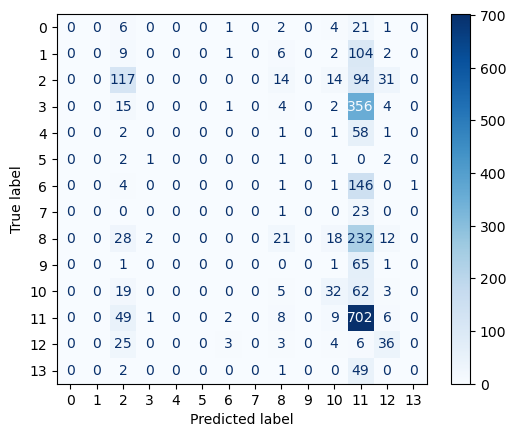

In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = logreg_model.predict(sequence_embeddings)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(my_test_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')  # You can choose a color map

# Metrics
accuracy = accuracy_score(my_test_labels, y_pred)
precision = precision_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else precision_score(my_test_labels, y_pred)
recall = recall_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else recall_score(my_test_labels, y_pred)
f1 = f1_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else f1_score(my_test_labels, y_pred)

# Calculate ROC AUC score
if num_classes > 2:
    # For multiclass ROC AUC
    y_test_binarized = label_binarize(my_test_labels, classes=np.arange(num_classes))
    y_pred_prob = logreg_model.predict_proba(sequence_embeddings)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(my_test_labels, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Model Evaluation Metrics:
Accuracy: 0.25060827250608275
Precision: 0.22696726749361984
Recall: 0.25060827250608275
F1 Score: 0.23457026187548058
ROC AUC Score: 0.5885326223513768


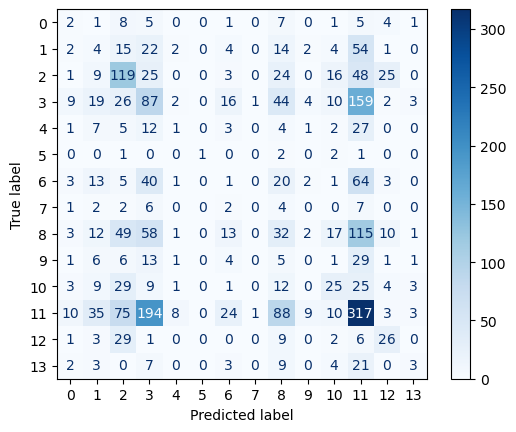

In [30]:
y_pred = knn_model.predict(sequence_embeddings)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(my_test_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')  # You can choose a color map

# Metrics
accuracy = accuracy_score(my_test_labels, y_pred)
precision = precision_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else precision_score(my_test_labels, y_pred)
recall = recall_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else recall_score(my_test_labels, y_pred)
f1 = f1_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else f1_score(my_test_labels, y_pred)

# Calculate ROC AUC score
if num_classes > 2:
    # For multiclass ROC AUC
    y_test_binarized = label_binarize(my_test_labels, classes=np.arange(num_classes))
    y_pred_prob = knn_model.predict_proba(sequence_embeddings)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(my_test_labels, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Evaluation Metrics:
Accuracy: 0.36171938361719386
Precision: 0.19890649335671476
Recall: 0.36171938361719386
F1 Score: 0.2382059889808882
ROC AUC Score: 0.6665036589709971


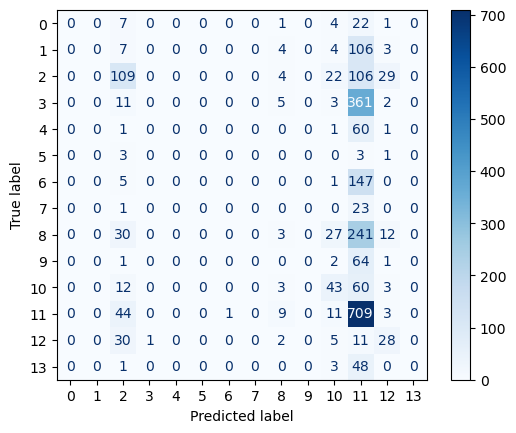

In [31]:
y_pred = mlp_model.predict(sequence_embeddings)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(my_test_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')  # You can choose a color map

# Metrics
accuracy = accuracy_score(my_test_labels, y_pred)
precision = precision_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else precision_score(my_test_labels, y_pred)
recall = recall_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else recall_score(my_test_labels, y_pred)
f1 = f1_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else f1_score(my_test_labels, y_pred)

# Calculate ROC AUC score
if num_classes > 2:
    # For multiclass ROC AUC
    y_test_binarized = label_binarize(my_test_labels, classes=np.arange(num_classes))
    y_pred_prob = mlp_model.predict_proba(sequence_embeddings)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(my_test_labels, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Model Evaluation Metrics:
Accuracy: 0.36171938361719386
Precision: 0.18222900930461877
Recall: 0.36171938361719386
F1 Score: 0.22599967579950098
ROC AUC Score: 0.6562607610665967


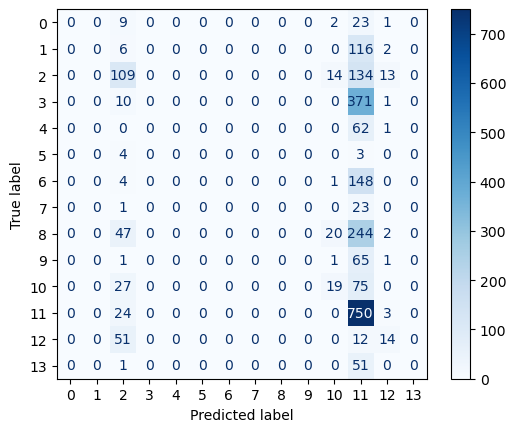

In [32]:
y_pred = svm_model.predict(sequence_embeddings)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(my_test_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')  # You can choose a color map

# Metrics
accuracy = accuracy_score(my_test_labels, y_pred)
precision = precision_score(my_test_labels, y_pred, average='weighted', zero_division=0) if num_classes > 2 else precision_score(my_test_labels, y_pred)
recall = recall_score(my_test_labels, y_pred, average='weighted', zero_division=0) if num_classes > 2 else recall_score(my_test_labels, y_pred)
f1 = f1_score(my_test_labels, y_pred, average='weighted', zero_division=0) if num_classes > 2 else f1_score(my_test_labels, y_pred)

# Calculate ROC AUC score
if num_classes > 2:
    # For multiclass ROC AUC
    y_test_binarized = label_binarize(my_test_labels, classes=np.arange(num_classes))
    y_pred_prob = svm_model.predict_proba(sequence_embeddings)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(my_test_labels, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Model Evaluation Metrics:
Accuracy: 0.23195458231954583
Precision: 0.23695328053700734
Recall: 0.23195458231954583
F1 Score: 0.2340551160091643
ROC AUC Score: 0.5423547860304635


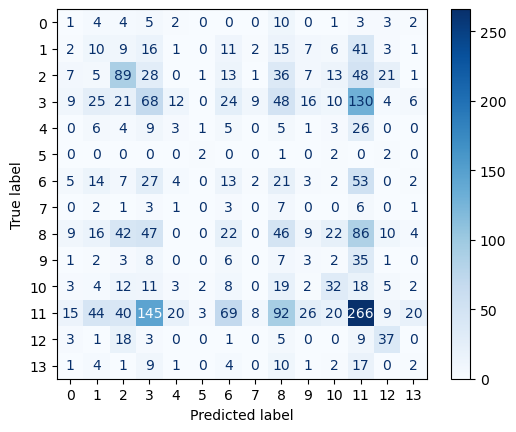

In [33]:
y_pred = dt_model.predict(sequence_embeddings)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(my_test_labels, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')  # You can choose a color map

# Metrics
accuracy = accuracy_score(my_test_labels, y_pred)
precision = precision_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else precision_score(my_test_labels, y_pred)
recall = recall_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else recall_score(my_test_labels, y_pred)
f1 = f1_score(my_test_labels, y_pred, average='weighted') if num_classes > 2 else f1_score(my_test_labels, y_pred)

# Calculate ROC AUC score
if num_classes > 2:
    # For multiclass ROC AUC
    y_test_binarized = label_binarize(my_test_labels, classes=np.arange(num_classes))
    y_pred_prob = dt_model.predict_proba(sequence_embeddings)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(my_test_labels, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

In [34]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

# After obtaining sequence embeddings, feed them into the FCN model for inference
predictions = []
true_labels = []

X_test_tensor = torch.tensor(sequence_embeddings, dtype=torch.float32)  # embeddings obtained from LSTM
y_test_tensor = torch.tensor(my_test_labels, dtype=torch.long)  # labels

with torch.no_grad():
    fcn_model.eval()  # Set model to evaluation mode
    
    # Feed sequence embeddings into FCN model
    outputs = fcn_model(X_test_tensor)
    outputs_prob = torch.softmax(outputs, dim=1).numpy()
    
    if num_classes > 2:
        # For multiclass classification
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.numpy()
    else:
        # For binary classification
        predicted = (torch.sigmoid(outputs.squeeze()) >= 0.5).long().numpy()
        
    # Convert predictions and true labels to lists
    predictions.extend(predicted.tolist())
    true_labels.extend(y_test_tensor.numpy().tolist())

# Calculate metrics
conf_matrix = confusion_matrix(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted') if num_classes > 2 else precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions, average='weighted') if num_classes > 2 else recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted') if num_classes > 2 else f1_score(true_labels, predictions)

# ROC AUC score is not applicable for multiclass classification
# Calculate ROC AUC score
if num_classes > 2:
    # Binarize the true labels for multiclass
    y_test_binarized = label_binarize(true_labels, classes=np.arange(num_classes))
    roc_auc = roc_auc_score(y_test_binarized, outputs_prob, multi_class='ovr', average='weighted')
else:
    roc_auc = roc_auc_score(true_labels, predictions)
    
# Print metrics
print("Model Evaluation Metrics:")
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Model Evaluation Metrics:
Confusion Matrix:
 [[  0   0  12   0   0   0   0   0   0   0   0  23   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0 114   0   0]
 [  0   0 134   0   0   0   0   0   0   0   0 122  14   0]
 [  0   0  18   0   0   0   0   0   0   0   0 363   1   0]
 [  0   0   2   0   0   0   0   0   0   0   0  61   0   0]
 [  0   0   4   0   0   0   0   0   0   0   0   3   0   0]
 [  0   0   6   0   0   0   0   0   0   0   0 147   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0  23   0   0]
 [  0   0  61   0   0   0   0   0   0   0   0 244   8   0]
 [  0   0   1   0   0   0   0   0   0   0   0  66   1   0]
 [  0   0  56   0   0   0   0   0   0   0   0  65   0   0]
 [  0   0  46   0   0   0   0   0   0   0   0 730   1   0]
 [  0   0  47   0   0   0   0   0   0   0   0  12  18   0]
 [  0   0   2   0   0   0   0   0   0   0   0  50   0   0]]
Accuracy: 0.35766423357664234
Precision: 0.16344816746833135
Recall: 0.35766423357664234
F1 Score: 0.21745742092457426
ROC AUC S

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#--------------------------------------------------------------#
# Version Date: Sept 4, 2024
#--------------------------------------------------------------#